# Simple Moving Average Backtest

Firstly, lets import all of the dependencies we need:

In [23]:
import yfinance as yf
import matplotlib.pyplot as plt

## Variable Setup

In the following set the variables up you would like to run the SMA backtest for (dates are of the format 'yyyy-mm-dd'):

In [2]:
ticker_symbol = 'MSFT'
start_date = '2020-11-01'
end_date = '2020-11-30'

## Get the Stock Price Data

Get the data as defined by the previous and visualise:

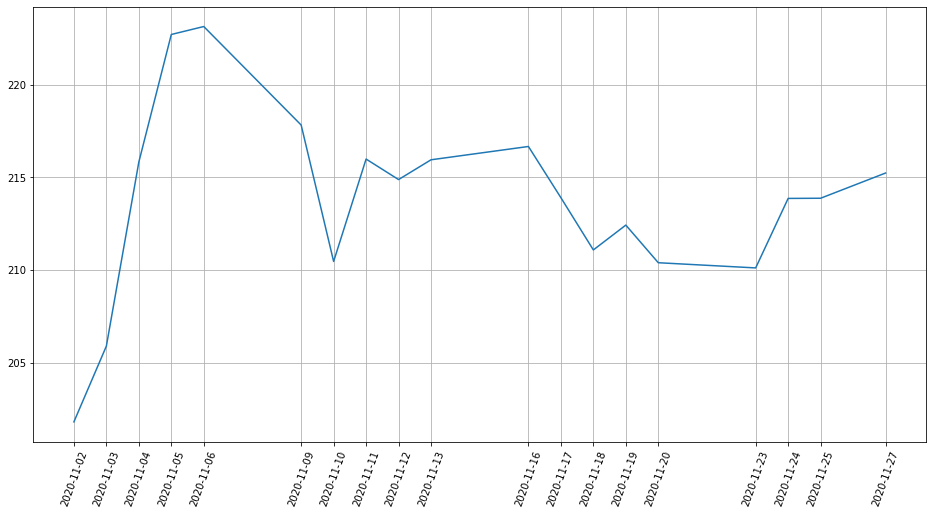

In [33]:
stock_price_data = yf.Ticker("MSFT")
hist = stock_price_data.history(start='2020-11-01', end='2020-11-30')

plt.figure(figsize=(16,8)) 
plt.plot(hist.index, hist['Close'])
plt.xticks(hist.index, rotation=70)
plt.grid()
plt.show()